In [1]:
import pandas as pd
from langchain.schema import Document

file1 = "/home/Preda/user/Sony_InternProj/data/20240919/マニュアルQA(初級RAG)_with_scores のコピー.xlsx"
df1 = pd.read_excel(file1)
df1 = df1[:52]

def convert_to_documents(cell):
    if pd.isna(cell):
        return None  # 如果是NaN，直接返回
    try:
        documents_data = eval(cell)
        if isinstance(documents_data, list):
            documents = []
            for doc_tuple in documents_data:
                # doc_tuple 是 (Document, score) 的形式
                doc_obj, _ = doc_tuple  # 因为 doc_tuple 是 (Document, score) 的形式
                if isinstance(doc_obj, Document):
                    documents.append(doc_obj)
                
            return documents
        else:
            return cell
    except Exception as e:
        print(f"Error parsing cell: {e}")
        return cell

df1['検索結果'] = df1['検索結果'].apply(convert_to_documents)
df1["source_path"] = df1.apply(lambda row: [sp.metadata["source_path"] for sp in row["検索結果"]], axis=1)

## RAG初級

In [2]:
from typing import Optional, Any, List
import time, datetime
from dotenv import load_dotenv
import os
import re
import numpy as np
import faiss
from datasets import Dataset
from ragas import evaluate
import glob
import yaml
from openai import AzureOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings
from langchain_community.vectorstores.faiss import FAISS
from langchain.schema import Document
from ragas.metrics import (
    context_precision,
    answer_relevancy,
    faithfulness,
    answer_correctness,
)
from transformers import BertJapaneseTokenizer
from nltk.translate.meteor_score import meteor_score
from sudachipy import dictionary, tokenizer
import re
import time

load_dotenv()

def create_embeddings_model(
    model_name = "text-embedding-3-large",
    chunk_size: int = 2048,
    api_key = os.environ["OPENAI_API_KEY"],
    api_version = "2024-02-01",
    azure_endpoint = "https://azure-preone-openai-sweden-central-01-chen.openai.azure.com/",
):
    # Create an AzureOpenAIEmbeddings model
    return AzureOpenAIEmbeddings(
        model=model_name,
        chunk_size=chunk_size,
        api_key=api_key,
        api_version=api_version,
        azure_endpoint=azure_endpoint,
    )

def create_chat_model(
    model_name = "gpt-4o",
    api_key = os.environ["OPENAI_API_KEY"],
    api_version = "2024-02-01",
    temperature: float = 0,
    azure_endpoint = "https://azure-preone-openai-sweden-central-01-chen.openai.azure.com/",
):
    # Create an AzureChatOpenAI model
    return AzureChatOpenAI(
        model=model_name,
        api_key=api_key,
        api_version=api_version,
        azure_endpoint=azure_endpoint,
        temperature=temperature,
    )


In [3]:
def find_jp_md_files(root_dir):
    jp_md_files = []
    for dir_path, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.jp.md'):
                full_path = os.path.join(dir_path, file)
                jp_md_files.append(full_path)
    return jp_md_files

def preprocess_metadata(metadata_str):
    return metadata_str.replace("\t", " ")

def extract_metadata(metadata_str):
    metadata_str = preprocess_metadata(metadata_str)
    metadata = yaml.safe_load(metadata_str)
    return {
        "title":metadata.get("title", "").strip(""),
        "description": metadata.get("meta", {}).get("description", "").strip(""),
        "keywords": ",".join([k.strip("") for k in metadata.get("keywords", [])])
    }

def extract_path(file_path):
    # Extract the relevant path from the file path
    parts = file_path.split("content/")
    if len(parts) > 1:
        relevant_path = parts[1]
        relevant_path = os.path.dirname(relevant_path)
        return relevant_path
    return ""

def process_md_files(jp_md_files: List[str]) -> List[Document]:
    # Read all markdown files and extract metadata, content
    all_chunks = []
    for file_path in jp_md_files:
        with open(file_path, 'r', encoding='utf-8') as f:
            markdown_content = f.read()
        parts = markdown_content.split('---', 2)
        if len(parts) < 3:
            print(f"Skipping file {file_path}: Invalid format")
            continue

        # Extract metadata
        try:
            metadata_str = parts[1].strip("\n")
            extract_meta_dict = extract_metadata(metadata_str)
        except yaml.YAMLError:
            print(f"Error: Unable to parse YAML in {file_path}")
            continue

        # Extract content and source path
        content = parts[2].strip("\n")
        source_path = extract_path(file_path)

        # Split content based on headers
        headers_to_split_on = [
            ("#", "H1"),
            ("##", "H2"),
            ("###", "H3"),
            ("####", "H4"),
            ("#####", "H5"),
            ("######", "H6"),
        ]
        markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
        splits = markdown_splitter.split_text(content)

        # Create Document objects
        for split in splits:
            combined_text = f"Title: {extract_meta_dict['title']}\n"
            combined_text += f"Description: {extract_meta_dict['description']}\n"
            combined_text += f"Keywords: {extract_meta_dict['keywords']}\n"
            if split.metadata:
                for header_level in ["H1", "H2", "H3", "H4", "H5", "H6"]:
                    if header_level in split.metadata:
                        combined_text += f"Subtitle: {split.metadata[header_level]}\n"
                        break
            combined_text += f"Content: {split.page_content}\n"

            # Create the document with source_path in metadata
            doc = Document(
                page_content=combined_text,
                metadata={
                    "title": extract_meta_dict["title"],
                    "description": extract_meta_dict["description"],
                    "keywords": extract_meta_dict["keywords"],
                    "source_path": source_path,
                }
            )
            all_chunks.append(doc)
    return all_chunks

root_dir = "/home/Preda/user/Sony_InternProj/content"
jp_md_files = find_jp_md_files(root_dir)
all_chunks = process_md_files(jp_md_files)

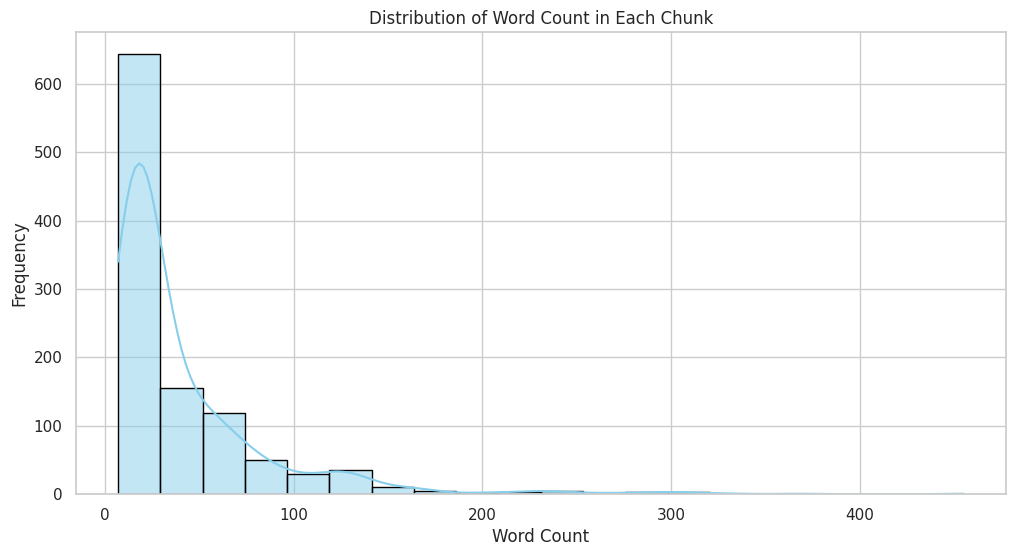

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 all_chunks 是一个包含多个 chunk 的列表
# 每个 chunk 是一个字典，包含键 'page_content'
# all_chunks = [{'page_content': '...'}, ...]

# 计算每个 chunk 中 'page_content' 的字数
word_counts = [len(chunk.page_content.split()) for chunk in all_chunks]

# 设置图形风格
sns.set(style="whitegrid")

# 创建一个图形和子图
plt.figure(figsize=(12, 6))

# 直方图和 KDE 图的组合
sns.histplot(word_counts, kde=True, color='skyblue', bins=20, edgecolor='black')

# 添加标题和标签
plt.title('Distribution of Word Count in Each Chunk')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# 显示图形
plt.show()

In [4]:
def calculate_precision_recall(df, all_chunks):
    # Initialize precision@k, recall@k, and count columns
    df["DocumentCount"] = 0
    df["Precision@k"] = 0.0
    df["Recall@k"] = 0.0

    for index, row in df.iterrows():
        retrieved_docs = row["検索結果"]

        # 检查 retrieved_docs 是否为列表并且不为空
        if not isinstance(retrieved_docs, list) or len(retrieved_docs) == 0:
            continue

        # 计数検索結果中的 Document 数量
        doc_count = len(retrieved_docs)
        df.at[index, "DocumentCount"] = doc_count

        # 检查 "マニュアル該当箇所" 是否为字符串
        if not isinstance(row["マニュアル該当箇所"], str):
            continue

        # 计算全局相关文档总数
        relevant_docs_total = sum(
            1 for chunk in all_chunks if chunk.metadata["source_path"] in row["マニュアル該当箇所"].split("\n")
        )
        print(f"Row {index}: Relevant docs total: {relevant_docs_total}")  # 调试输出
        if relevant_docs_total == 0:
            continue

        relevant_count_in_retrieved = 0
        for document_obj in retrieved_docs:
            # 直接使用 Document 对象
            if isinstance(document_obj, Document):
                print(f"Document source_path: {document_obj.metadata['source_path']}")  # 调试输出
                if document_obj.metadata["source_path"] in row["マニュアル該当箇所"].split("\n"):
                    relevant_count_in_retrieved += 1

        # 计算 Precision@k 和 Recall@k
        precision = relevant_count_in_retrieved / doc_count if doc_count > 0 else 0
        recall = relevant_count_in_retrieved / relevant_docs_total if relevant_docs_total > 0 else 0

        # 更新 DataFrame
        df.at[index, "Precision@k"] = precision
        df.at[index, "Recall@k"] = recall

    return df

# 应用函数
df1 = calculate_precision_recall(df1, all_chunks)

Row 0: Relevant docs total: 3
Document source_path: terminology/corr
Document source_path: terminology/corr
Document source_path: terminology/corr
Document source_path: tips/new_features/score
Document source_path: terminology/join_relational_data
Row 1: Relevant docs total: 20
Document source_path: tips/new_features/contribution_csv
Document source_path: tips/new_features/contribution_csv
Document source_path: tips/new_features/contribution_csv
Document source_path: tips/new_features/contribution_csv
Document source_path: tips/new_features/contribution_csv
Row 2: Relevant docs total: 3
Document source_path: terminology/string
Document source_path: tips/advice/advice_23101
Document source_path: terminology/string
Document source_path: terminology/text
Document source_path: prediction_one/knowledge_of_predictive_analytics/one_hot_encoding
Row 5: Relevant docs total: 3
Document source_path: trouble/createmodel/missing_value
Document source_path: terminology/missing_value
Document source_

In [6]:
df1.to_excel("/home/Preda/user/Sony_InternProj/data/20240919/マニュアルQA(初級RAG)_with_scores のコピー.xlsx")

In [5]:
df1[df1["マニュアル該当箇所"].notna()]

,QA番号,担当,質問カテゴリ,質問,答え（マニュアルのみ参照）,答え（マニュアル+一般知識）,マニュアル該当箇所,参考,生成答え,検索結果,source_path,DocumentCount,Precision@k,Recall@k,METEOR,faithfulness,answer_relevancy,context_precision,answer_correctness
0,NaN,山本,NaN,予測したい項目との関連度や相関係数とは何ですか？,関連度スコアとは、その項目と予測したい項目との間の関連度を示したものです。\n具体的には以下...,関連度スコアとは、その項目と予測したい項目との間の関連度を示したものです。\n具体的には以下...,terminology/corr,C&R FAQ 2\n相関係数についてマニュアルに記載はない,予測したい項目との関連度や相関係数は、その項目と予測対象となる項目間の関連性や関係性を数値化...,[page_content='Title: 関連度スコア\nDescription: 関連度...,"[terminology/corr, terminology/corr, terminolo...",5,0.6,1.000000,0.047619,0.400000,0.450839,1.000000,0.286911
1,NaN,山本,NaN,寄与度をプレゼンに使おうとしていて、寄与度のバーチャート(添付しています)を、エクセルで再現...,二値分類の場合、「顧客行動予測に基づいたターゲティングのチュートリアル」の例だと、赤や青のバ...,二値分類の場合、「顧客行動予測に基づいたターゲティングのチュートリアル」の例だと、赤や青のバ...,tips/new_features/contribution_csv,C&R FAQ 4,まず、CSVファイルをエクセルにインポートします。その後、以下の手順で赤と青の割合を再現しま...,[page_content='Title: 予測寄与度のcsv出力\nDescription...,"[tips/new_features/contribution_csv, tips/new_...",5,1.0,0.250000,0.010846,NaN,0.554063,1.000000,0.897431
2,NaN,山本,NaN,説明変数に文字データを選択する際、文字列orテキストで選ぶことができるかと思いますが、この2...,たとえばアンケートにおいて現在済んでいる県を選択する欄などの、 いくつかの限定された種類の文...,たとえばアンケートにおいて現在済んでいる県を選択する欄などの、 いくつかの限定された種類の文...,terminology/string\ntips/advice/advice_23101,C&R FAQ 9,文字データの扱いは以下のように使い分けると効果的です。\n\n**文字列型**:\n- **...,[page_content='Title: 文字列の処理\nDescription: たとえ...,"[terminology/string, tips/advice/advice_23101,...",5,0.6,1.000000,0.013699,0.450000,0.450050,1.000000,0.717601
5,NaN,山本,NaN,学習に必要なデータセットの空欄の扱いについて質問です。\nデータセットの説明の中に、不明部分...,空欄は実際の値が不明である状態として扱います。\n\n学習に使用する項目が欠損している場合\...,空欄は実際の値が不明である状態として扱います。\n\n学習に使用する項目が欠損している場合\...,terminology/missing_value,C&R FAQ 13,空欄は「欠損値」として扱われます。「欠損値」は特定の項目の情報が不明であることを示し、予測モ...,[page_content='Title: データ作成の際に、取得できない値がある場合は (...,"[trouble/createmodel/missing_value, terminolog...",5,0.6,1.000000,0.036496,0.500000,0.446525,1.000000,0.471450
6,NaN,山本,NaN,決定係数でマイナスの値が出るのですが、これはどういった意味ですか？,決定係数とは、数値予測のモデルの良さを測る指標の一つです。一般的に高ければ高いほどよく、最良...,決定係数とは、数値予測のモデルの良さを測る指標の一つです。一般的に高ければ高いほどよく、最良...,terminology/r2,C&R FAQ 14,決定係数（R²）がマイナスになるのは、モデルが定数モデル（平均値のみを使った予測）よりも悪い...,[page_content='Title: 決定係数\nDescription: 決定係数と...,"[terminology/r2, trouble/createmodel/error_rat...",5,0.2,1.000000,0.050000,0.000000,0.707112,1.000000,0.498063
7,NaN,山本,NaN,Prediction Oneを自分たちで作ったソフトからコントロールできるようなツールはあり...,Web API経由で各種操作を実行できる「API機能」があります。,Web API経由で各種操作を実行できる「API機能」があります。,operating_instruction/api,C&R FAQ 17,はい、Prediction Oneはコマンドライン機能を提供しており、これを利用して自作ソフ...,[page_content='Title: Prediction Oneとは\nDescri...,"[prediction_one, prediction_one/process_of_pre...",5,0.0,0.000000,0.104167,NaN,0.472545,1.000000,0.849767
8,NaN,山本,NaN,業務で横書きのデータを使っています。Prediction Oneは横書きのデータでも読み込め...,Prediction Oneで日時項目として読み取るためには、日付や時刻を特定のフォーマット...,Prediction Oneで日時項目として読み取るためには、日付や時刻を特定のフォーマット...,tutorial/data_preparation/timeseries_convert_f...,C&R FAQ 18,はい、Prediction Oneは横書きのデータを読み込むことができます。対応しているファ...,[page_content='Title: その他の仕様\nDescription: Pre...,"[tips/specification/others, trouble/createmode...",5,0.0,0.000000,0.128205,0.333333,0.621532,1.000000,0.422312
9,NaN,山本,NaN,ある測定値に対して、どの程度影響を与えているかわからない数値パラメータ（約10種）を入れたデ...,寄与度のほかには、その項目と予測したい項目との間の関連度を示した関連度すコアがあります。\n...,寄与度のほかには、その項目と予測したい項目との間の関連度を示した関連度すコアがあります。\n...,terminology/corr\ntips/new_features/contributi...,C&R FAQ 19,・**他の手法**:\n 高度な解析手法として、「相関行列の生成」や「SHAP値（Shap...,[page_content='Title: 4.2 寄与度を確認する\nDescriptio...,[prediction_one/process_of_predictive_analytic...,5,0.0,0.000000,0.024155,0.000000,0.311505,0.963394,0.882540
10,NaN,山本,NaN,PredictionOneは、ユーザのレビュー文など自然言語文を入力することができますが、そ...,データタイプがテキストの場合は、内部的にそこに含まれる単語の出現頻度が予測モデルに使用されま...,データタイプがテキストの場合は、内部的にそこに含まれる単語の出現頻度が予測モデルに使用されま...,tips/advice/advice_23101,C&R FAQ 20,PredictionOneは、ユーザのレビュー文など自然言語文を入力可能ですが、具体的な内部...,[page_content='Title: ストーリー ～レビュー文のラベリング作業の自動化...,[tutorial/crm_automate_voice_of_the_customer_l...,5,0.0,0.000000,0.031250,0.000000,0.000000,0.000000,0.331933
11,NaN,山本,NaN,精度が良い結果を得るためには列（パラメータ）に対しN数がどの程度あればよいか、教えていただけ...,一般的に、予測モデル作成用データの行数を増やせば増やすほど、精度は改善します。ただし、精度の...,

In [8]:
from sudachipy import tokenizer as sudachi_tokenizer
from sudachipy import dictionary
from nltk.translate.meteor_score import meteor_score as nltk_meteor_score

def custom_meteor_score(ground_truth, generated):
    tokenizer_obj = dictionary.Dictionary().create()
    def tokenize(text):
        return [m.surface() for m in tokenizer_obj.tokenize(text, sudachi_tokenizer.Tokenizer.SplitMode.C)]
    tokenized_answer = tokenize(generated)
    tokenized_ground_truth = [tokenize(ref) for ref in ground_truth]
    score = nltk_meteor_score(tokenized_ground_truth, tokenized_answer)
    return score



df1["METEOR"] = df1.apply(lambda row: custom_meteor_score(row["答え（マニュアル+一般知識）"], row["生成答え"]), axis=1)
df1

,QA番号,担当,質問カテゴリ,質問,答え（マニュアルのみ参照）,答え（マニュアル+一般知識）,マニュアル該当箇所,参考,生成答え,検索結果,source_path,DocumentCount,Precision@k,Recall@k,METEOR
0,NaN,山本,NaN,予測したい項目との関連度や相関係数とは何ですか？,関連度スコアとは、その項目と予測したい項目との間の関連度を示したものです。\n具体的には以下...,関連度スコアとは、その項目と予測したい項目との間の関連度を示したものです。\n具体的には以下...,terminology/corr,C&R FAQ 2\n相関係数についてマニュアルに記載はない,予測したい項目との関連度や相関係数は、その項目と予測対象となる項目間の関連性や関係性を数値化...,[page_content='Title: 関連度スコア\nDescription: 関連度...,"[terminology/corr, terminology/corr, terminolo...",10,0.3,1.000000,0.047619
1,NaN,山本,NaN,寄与度をプレゼンに使おうとしていて、寄与度のバーチャート(添付しています)を、エクセルで再現...,二値分類の場合、「顧客行動予測に基づいたターゲティングのチュートリアル」の例だと、赤や青のバ...,二値分類の場合、「顧客行動予測に基づいたターゲティングのチュートリアル」の例だと、赤や青のバ...,tips/new_features/contribution_csv,C&R FAQ 4,まず、CSVファイルをエクセルにインポートします。その後、以下の手順で赤と青の割合を再現しま...,[page_content='Title: 予測寄与度のcsv出力\nDescription...,"[tips/new_features/contribution_csv, tips/new_...",10,1.0,0.500000,0.010846
2,NaN,山本,NaN,説明変数に文字データを選択する際、文字列orテキストで選ぶことができるかと思いますが、この2...,たとえばアンケートにおいて現在済んでいる県を選択する欄などの、 いくつかの限定された種類の文...,たとえばアンケートにおいて現在済んでいる県を選択する欄などの、 いくつかの限定された種類の文...,terminology/string\ntips/advice/advice_23101,C&R FAQ 9,文字データの扱いは以下のように使い分けると効果的です。\n\n**文字列型**:\n- **...,[page_content='Title: 文字列の処理\nDescription: たとえ...,"[terminology/string, tips/advice/advice_23101,...",10,0.3,1.000000,0.013699
3,NaN,山本,NaN,データセットとして画像ファイルを利用することは可能でしょうか？画像と数値の組み合わせを学習デ...,マニュアルにデータセットとして画像ファイルを利用することに関する記述はありません。,申し訳ありませんがPrediction Oneで利用できるデータセットは表形式データ(csv...,NaN,C&R FAQ 10,画像ファイルをデータセットとして利用することは可能です。しかし、Prediction One...,[page_content='Title: 学習に使用する数値ベクトルを生成できませんでした...,"[trouble/message/e78, trouble/createmodel/clas...",10,0.0,0.000000,0.028902
4,NaN,山本,NaN,Prediction Oneにおいては、数値予測のモデルを作成したいとき、パラメータを選択す...,マニュアルに多重共線性に関する記述はありません。,数値予測をするにあたっては、多重共線性がある項目もそのまま使用していただいて問題ありません。...,NaN,C&R FAQ 12,はい、数値予測モデルを作成する際には多重共線性をケアする必要があります。多重共線性が存在する...,[page_content='Title: 系列数を増やして同時に予測モデルの作成を行いまし...,"[tips/advice/advice_20503, prediction_one/know...",10,0.0,0.000000,0.070423
5,NaN,山本,NaN,学習に必要なデータセットの空欄の扱いについて質問です。\nデータセットの説明の中に、不明部分...,空欄は実際の値が不明である状態として扱います。\n\n学習に使用する項目が欠損している場合\...,空欄は実際の値が不明である状態として扱います。\n\n学習に使用する項目が欠損している場合\...,terminology/missing_value,C&R FAQ 13,空欄は「欠損値」として扱われます。「欠損値」は特定の項目の情報が不明であることを示し、予測モ...,[page_content='Title: データ作成の際に、取得できない値がある場合は (...,"[trouble/createmodel/missing_value, terminolog...",10,0.3,1.000000,0.036496
6,NaN,山本,NaN,決定係数でマイナスの値が出るのですが、これはどういった意味ですか？,決定係数とは、数値予測のモデルの良さを測る指標の一つです。一般的に高ければ高いほどよく、最良...,決定係数とは、数値予測のモデルの良さを測る指標の一つです。一般的に高ければ高いほどよく、最良...,terminology/r2,C&R FAQ 14,決定係数（R²）がマイナスになるのは、モデルが定数モデル（平均値のみを使った予測）よりも悪い...,[page_content='Title: 決定係数\nDescription: 決定係数と...,"[terminology/r2, trouble/createmodel/error_rat...",10,0.1,1.000000,0.050000
7,NaN,山本,NaN,Prediction Oneを自分たちで作ったソフトからコントロールできるようなツールはあり...,Web API経由で各種操作を実行できる「API機能」があります。,Web API経由で各種操作を実行できる「API機能」があります。,operating_instruction/api,C&R FAQ 17,はい、Prediction Oneはコマンドライン機能を提供しており、これを利用して自作ソフ...,[page_content='Title: Prediction Oneとは\nDescri...,"[prediction_one, prediction_one/process_of_pre...",10,0.0,0.000000,0.104167
8,NaN,山本,NaN,業務で横書きのデータを使っています。Prediction Oneは横書きのデータでも読み込め...,Prediction Oneで日時項目として読み取るためには、日付や時刻を特定のフォーマット...,Prediction Oneで日時項目として読み取るためには、日付や時刻を特定のフォーマット...,tutorial/data_preparation/timeseries_convert_f...,C&R FAQ 18,はい、Prediction Oneは横書きのデータを読み込むことができます。対応しているファ...,[page_content='Title: その他の仕様\nDescription: Pre...,"[tips/specification/others, trouble/createmode...",10,0.0,0.000000,0.128205
9,NaN,山本,NaN,ある測定値に対して、どの程度影響を与えているかわからない数値パラメータ（約10種）を入れたデ...,寄与度のほかには、その項目と予測したい項目との間の関連度を示した関連度すコアがあります。\n...,寄与度のほかには、その項目と予測したい項目との間の関連度を示した関連度すコアがあります。\n...,terminology/corr\ntips/new_features/contributi...,C&R FAQ 19,・**他の手法**:\n 高度な解析手法として、「相関行列の生成」や「SHAP値（Shap...,[page_content='Title: 4.2 寄与度を確認する\nDescriptio...,[prediction_one/process_of_predictive_analytic...,10,0.0,0.000000,0.024155


In [17]:
from ragas.metrics import (
    context_precision,
    answer_relevancy,
    faithfulness,
    answer_correctness,
)

def extract_contexts(row, all_chunks):
    if isinstance(row["マニュアル該当箇所"], str) and row["マニュアル該当箇所"].strip():
        # 保留每个上下文内容作为独立的字符串
        return [str(chunk.page_content) for chunk in all_chunks if chunk.metadata["source_path"] in row["マニュアル該当箇所"].split("\n")]
    else:
        return []

def calculate_ragas_for_row(row, all_chunks):
    # 提取当前行的上下文、问题、答案和真实答案
    contexts = extract_contexts(row, all_chunks)
    ground_truth = row['答え（マニュアル+一般知識）']
    answer = row["生成答え"]
    question = row["質問"]

    # 确保 contexts 是一个字符串列表
    if not contexts:
        contexts = [""]  # 如果 contexts 为空，用一个空字符串填充

    # 创建单行数据集，contexts 保持为一个列表中的列表
    ds = Dataset.from_dict(
        {
            "question": [question],
            "answer": [answer],
            "contexts": [contexts],  # contexts 是一个字符串列表
            "ground_truth": [ground_truth],
        }
    )

    # 定义指标
    metrics = [
        faithfulness,
        answer_relevancy,
        context_precision,
        answer_correctness,
    ]

    # 评估当前行
    result = evaluate(
        ds,
        metrics=metrics,
        llm=create_chat_model(),  # 使用 llm 模型
        embeddings=create_embeddings_model(),  # 使用 embeddings 模型
    )
    
    # 返回每个指标的分数
    scores = {metric.name: result[metric.name] for metric in metrics}
    return scores

# 使用 apply 逐行计算 RAGAS 分数
scores_df = df1.apply(lambda row: calculate_ragas_for_row(row, all_chunks), axis=1)

# 将每个指标的分数添加到原 DataFrame 中
for metric_name in scores_df.iloc[0].keys():
    df1[metric_name] = scores_df.apply(lambda x: x[metric_name])


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Exception raised in Job[2]: TimeoutError()
Exception raised in Job[1]: TimeoutError()


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

No statements were generated from the answer.


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

In [18]:
df1

,QA番号,担当,質問カテゴリ,質問,答え（マニュアルのみ参照）,答え（マニュアル+一般知識）,マニュアル該当箇所,参考,生成答え,検索結果,source_path,DocumentCount,Precision@k,Recall@k,METEOR,ragas_score,faithfulness,answer_relevancy,context_precision,answer_correctness
0,NaN,山本,NaN,予測したい項目との関連度や相関係数とは何ですか？,関連度スコアとは、その項目と予測したい項目との間の関連度を示したものです。\n具体的には以下...,関連度スコアとは、その項目と予測したい項目との間の関連度を示したものです。\n具体的には以下...,terminology/corr,C&R FAQ 2\n相関係数についてマニュアルに記載はない,予測したい項目との関連度や相関係数は、その項目と予測対象となる項目間の関連性や関係性を数値化...,[page_content='Title: 関連度スコア\nDescription: 関連度...,"[terminology/corr, terminology/corr, terminolo...",10,0.3,1.000000,0.047619,NaN,0.400000,0.450839,1.000000,0.286911
1,NaN,山本,NaN,寄与度をプレゼンに使おうとしていて、寄与度のバーチャート(添付しています)を、エクセルで再現...,二値分類の場合、「顧客行動予測に基づいたターゲティングのチュートリアル」の例だと、赤や青のバ...,二値分類の場合、「顧客行動予測に基づいたターゲティングのチュートリアル」の例だと、赤や青のバ...,tips/new_features/contribution_csv,C&R FAQ 4,まず、CSVファイルをエクセルにインポートします。その後、以下の手順で赤と青の割合を再現しま...,[page_content='Title: 予測寄与度のcsv出力\nDescription...,"[tips/new_features/contribution_csv, tips/new_...",10,1.0,0.500000,0.010846,NaN,NaN,0.554063,1.000000,0.897431
2,NaN,山本,NaN,説明変数に文字データを選択する際、文字列orテキストで選ぶことができるかと思いますが、この2...,たとえばアンケートにおいて現在済んでいる県を選択する欄などの、 いくつかの限定された種類の文...,たとえばアンケートにおいて現在済んでいる県を選択する欄などの、 いくつかの限定された種類の文...,terminology/string\ntips/advice/advice_23101,C&R FAQ 9,文字データの扱いは以下のように使い分けると効果的です。\n\n**文字列型**:\n- **...,[page_content='Title: 文字列の処理\nDescription: たとえ...,"[terminology/string, tips/advice/advice_23101,...",10,0.3,1.000000,0.013699,NaN,0.450000,0.450050,1.000000,0.717601
3,NaN,山本,NaN,データセットとして画像ファイルを利用することは可能でしょうか？画像と数値の組み合わせを学習デ...,マニュアルにデータセットとして画像ファイルを利用することに関する記述はありません。,申し訳ありませんがPrediction Oneで利用できるデータセットは表形式データ(csv...,NaN,C&R FAQ 10,画像ファイルをデータセットとして利用することは可能です。しかし、Prediction One...,[page_content='Title: 学習に使用する数値ベクトルを生成できませんでした...,"[trouble/message/e78, trouble/createmodel/clas...",10,0.0,0.000000,0.028902,NaN,NaN,0.563972,0.000000,0.812533
4,NaN,山本,NaN,Prediction Oneにおいては、数値予測のモデルを作成したいとき、パラメータを選択す...,マニュアルに多重共線性に関する記述はありません。,数値予測をするにあたっては、多重共線性がある項目もそのまま使用していただいて問題ありません。...,NaN,C&R FAQ 12,はい、数値予測モデルを作成する際には多重共線性をケアする必要があります。多重共線性が存在する...,[page_content='Title: 系列数を増やして同時に予測モデルの作成を行いまし...,"[tips/advice/advice_20503, prediction_one/know...",10,0.0,0.000000,0.070423,NaN,NaN,0.534453,0.000000,0.157915
5,NaN,山本,NaN,学習に必要なデータセットの空欄の扱いについて質問です。\nデータセットの説明の中に、不明部分...,空欄は実際の値が不明である状態として扱います。\n\n学習に使用する項目が欠損している場合\...,空欄は実際の値が不明である状態として扱います。\n\n学習に使用する項目が欠損している場合\...,terminology/missing_value,C&R FAQ 13,空欄は「欠損値」として扱われます。「欠損値」は特定の項目の情報が不明であることを示し、予測モ...,[page_content='Title: データ作成の際に、取得できない値がある場合は (...,"[trouble/createmodel/missing_value, terminolog...",10,0.3,1.000000,0.036496,NaN,0.500000,0.446525,1.000000,0.471450
6,NaN,山本,NaN,決定係数でマイナスの値が出るのですが、これはどういった意味ですか？,決定係数とは、数値予測のモデルの良さを測る指標の一つです。一般的に高ければ高いほどよく、最良...,決定係数とは、数値予測のモデルの良さを測る指標の一つです。一般的に高ければ高いほどよく、最良...,terminology/r2,C&R FAQ 14,決定係数（R²）がマイナスになるのは、モデルが定数モデル（平均値のみを使った予測）よりも悪い...,[page_content='Title: 決定係数\nDescription: 決定係数と...,"[terminology/r2, trouble/createmodel/error_rat...",10,0.1,1.000000,0.050000,NaN,0.000000,0.707112,1.000000,0.498063
7,NaN,山本,NaN,Prediction Oneを自分たちで作ったソフトからコントロールできるようなツールはあり...,Web API経由で各種操作を実行できる「API機能」があります。,Web API経由で各種操作を実行できる「API機能」があります。,operating_instruction/api,C&R FAQ 17,はい、Prediction Oneはコマンドライン機能を提供しており、これを利用して自作ソフ...,[page_content='Title: Prediction Oneとは\nDescri...,"[prediction_one, prediction_one/process_of_pre...",10,0.0,0.000000,0.104167,NaN,NaN,0.472545,1.000000,0.849767
8,NaN,山本,NaN,業務で横書きのデータを使っています。Prediction Oneは横書きのデータでも読み込め...,Prediction Oneで日時項目として読み取るためには、日付や時刻を特定のフォーマット...,Prediction Oneで日時項目として読み取るためには、日付や時刻を特定のフォーマット...,tutorial/data_preparation/timeseries_convert_f...,C&R FAQ 18,はい、Prediction Oneは横書きのデータを読み込むことができます。対応しているファ...,[page_content='Title: その他の仕様\nDescription: Pre...,"[tips/specification/others, trouble/createmode...",10,0.0,0.000000,0.128205,NaN,0.333333,0.621532,1.000000,0.422312
9,NaN,山本,NaN,ある測定値に対して、どの程度影響を与えているかわからない数値パラメータ（約10種）を入れたデ...,寄与度のほかには、その項目と予測したい項目との間の関連度を示した関連度すコアがあります。\n...,寄与度のほかには、その項目と予測したい項目との間の関連度を示した関連度すコアがあります。\n...,

In [19]:
df1.to_excel("/home/Preda/user/Sony_InternProj/data/20240918/マニュアルQA(初級RAG)_with_scores.xlsx", index=False)